# An attention based deep learning model of clinical events in the intensive care unit

---

* Name: Milad Parvaneh
* NetID: sparva2
* Team ID: 143
* Paper ID: 50
* Link to a public Github repository: https://github.com/miladparvaneh/CS598_DLH_Project-Draft.git

# Introduction

*   Background of the problem

  * Problem type: For my course project, I selected a study, from the provided list of papers, that employs a deep learning model for three prediction tasks in the intensive care unit (ICU) setting [1]. The paper uses long short-term memory (LSTM) equipped with an attention mechanism to predict clinical events, including daily sepsis, myocardial infarction, and vancomycin antibiotic administration.

  * Importance/meaning of solving the problem: Healthcare professionals in ICUs are required to process vast amounts of real-time data to make accurate diagnoses and implement the right treatments. With the rising admissions to ICUs, it becomes crucial to equip them with support tools for effective care delivery.

  * The difficulty of the problem: Traditional computer-assisted decision support systems in healthcare mainly rely on scoring systems derived from feature selection and logistic or hazard regression. These systems often perform poorly when applied to outcomes they were not designed to predict [2-3]. Additionally, they struggle to capture the non-linear relationships, which are common in healthcare topics. Despite the potential of traditional machine learning models to address these issues, their lack of interpretability has led to a preference for more transparent linear models in the past.

  * The state of the art methods and effectiveness: Machine learning (ML) prediction models, trained on relevant datasets, offer valuable assistance for these purposes. Within the array of ML techniques, deep learning in particular has demonstrated promising capabilities.

*   Paper explanation

  * What did the paper propose? The study [1] suggests training a recurrent neural network (RNN) in the form of LSTM with the inclusion of a variable-level attention mechanism.

  * What is the innovations of the method? The study claims that by integrating a variable-level attention mechanism, interpretability can be achieved directly at the input variable level, rather than within a more complex and less interpretable embedded space. To be more specific, this approach allows for variable-level attention, providing insights into which input variables, such as vital signs, lab results, medications, were most influential at different points in time for the model predictions.

  * How well the proposed method work (in its own metrics)? The study's deep learning model demonstrated robust performance in predicting three clinical events in an ICU setting: sepsis, myocardial infarction (MI), and vancomycin administration. The predictive performance of the model was measured using the area under the receiver operating characteristic curve (AUC), a common metric in machine learning for evaluating the accuracy of a binary classifier.

          Sepsis Prediction:

          Same-day AUC: 0.952
          Next-day AUC: 0.876

          Myocardial Infarction (MI) Prediction:

          Same-day AUC: 0.834
          Next-day AUC: 0.823

          Vancomycin Administration Prediction:

          Same-day AUC: 0.904
          Next-day AUC: 0.833

  * What are the contributions to the research regime (referring the Background above, how important the paper is to the problem)? The major contributions of this research to the clinical and machine learning fields include:

          Introduction of Attention Mechanisms in ICU Event Prediction
          Enhanced Interpretability
          High Predictive Performance
          Potential for Real-time Clinical Decision Support

        These contributions demonstrate a significant advancement in applying deep learning techniques to critical care, potentially leading to more informed and timely clinical decisions in ICUs.

# Scope of Reproducibility:

The study explores whether LSTMs, with an added variable-level attention mechanism, can effectively predict clinical outcomes in the ICU based on available patient data. This method seeks to make model interpretations more accessible for clinicians by highlighting critical daily data alongside the patient's ongoing clinical progression. Here are some highlights of what the study tries to investigate:


1.   Predicting clinical events with LSTM: The study hypothesizes that LSTM, trained on a comprehensive set of ICU admission variables, can accurately predict a variety of clinical events. This is a base hypothesis for this research, suggesting that deep learning can effectively handle the temporal and complex nature of ICU data to make meaningful predictions.

2.   Enhancement of model interpretability through variable-level attention: A key hypothesis of the study is that incorporating a variable-level attention mechanism can significantly enhance the interpretability of LSTM predictions for clinicians. Unlike traditional deep learning models that may act as black boxes, the attention mechanism is expected to highlight the input variables, e.g., vital signs, lab results, medications, that are most influential in making predictions at any given time. This approach seems to mirror the clinical decision-making process, where clinicians focus on the most pertinent information to diagnose and treat patients.

3.   Generalizability across different clinical outcomes: The research, implicitly, tests the hypothesis that a single deep learning architecture can be generalized to predict multiple clinical events, such as sepsis, myocardial infarction, and the administration of the antibiotic vancomycin. This hypothesis challenges the notion that different clinical outcomes require entirely separate models, suggesting instead that a flexible deep learning approach can accommodate various prediction tasks with appropriate training.

# Install Required Packages

In [ ]:
!pip install pyhealth

# Import Required Libraries

In [13]:
import random
import pickle
import numpy as np
from google.colab import drive
from pyhealth.datasets import MIMIC3Dataset
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Methodology

##  Data

  * Source of the data: The data used in this project is the MIMIC-III dataset. However, for this initial draft phase, a similar dataset is used, which is synthesized from the MIMIC-III and was used earlier by some of the Homeworks and Data Labs. Here is a a link to the raw datasets: https://storage.googleapis.com/pyhealth/Synthetic_MIMIC-III/. The main reason for using the synthesized version was the privacy concerns. For next phase of the project and after discussing with the TAs, the original MIMIC-III will be adopted.
  
  The original MIMIC-III dataset consists of anonymized data for over 40,000 patients from critical care units at Beth Israel Deaconess Medical Center from 2001 to 2012. It features patient demographics, hourly vital signs, lab results, procedures, medications, caregiver notes, imaging reports, and mortality information, including after hospital discharge. Although MIMIC-III is de-identified, it still needs user training before access can be granted. For that matter, I passed the ‘Data or Specimens Only Research’ course provided by the CITI program. I, then, applied and was approved for dataset access through PhysioNet.

  * Statistics:

    * Total number of patient: 12'872
    * Number of patients with sepsis: 3'218
    * Ratio of patients with sepsis: 0.25

      More statistics are printed out in the corresponding code snippet below.

  * Data process:
    * Among the three prediction tasks defined for this project, I initially dicided to work on sepsis prediction. Checking the raw dataset, it turns out that only 6% of the patients are diagnosed with sepsis (class imbalance). With 94% of the data belonging to the negative class, a machine learning model might learn to predominantly predict the majority class because doing so would still yield a high overall accuracy. For example, a naive model that always predicts 'negative' would be correct 94% of the time, misleadingly suggesting high performance. The model may fail to capture the patterns and characteristics of the positive class due to its underrepresentation. This often results in poor generalization capabilities when encountering new positive samples outside of the training set. Several techniques can be used to mitigate the effects of class imbalance, one of which is reducing the number of negative samples to balance the dataset. Here, I decided to drop a portion of negative samples and *randomly* keep around 10'000 which leads to 25% positive samples rate.

    * Additionally, including sepsis diagnosis codes directly within the input features (seqs) could bias the model. The model might learn simply to look for those codes rather than identifying patterns that predict sepsis before it's officially diagnosed. To make the model more practical and robust, it's a good idea to remove the sepsis-related diagnosis codes from the seqs before using them as input for training.

    * The dataset is splitted to train/valid sets as 80/20.

    * For the sepsis prediction task, the diagnosis instances within each visit for a given patient are considered as the input feature, for now. This keeps the model training computationally inexpensive while the prediction results are easy to interpret. At upcoming phases of the project, more feautes will be considered following those analyzed in the research paper.

### Reading Data from Saved File

Since importing the raw data and its pre-processing took significant time, I saved the resultant output file to be read later in the code. That is why some code snippets below are commented out. They were initially used to load and process the raw data, and are shown here as a reference. Later in the code, the proceesed data is read from a file named 'patient_data.pkl'.

In [ ]:
# This line of code was initially used to import the raw data
# mimic3_ds = MIMIC3Dataset(root = 'https://storage.googleapis.com/pyhealth/Synthetic_MIMIC-III/',
#         tables = ['DIAGNOSES_ICD', 'PRESCRIPTIONS', 'PROCEDURES_ICD'],
# )

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


finish basic patient information parsing : 101.92953133583069s


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


finish parsing DIAGNOSES_ICD : 71.49749422073364s


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


finish parsing PRESCRIPTIONS : 181.85107588768005s


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


finish parsing PROCEDURES_ICD : 58.98727369308472s


Mapping codes: 100%|██████████| 49993/49993 [00:01<00:00, 25824.03it/s]


In [ ]:
# mimic3_ds.info()


dataset.patients: patient_id -> <Patient>

<Patient>
    - visits: visit_id -> <Visit> 
    - other patient-level info
    
    <Visit>
        - event_list_dict: table_name -> List[Event]
        - other visit-level info
    
        <Event>
            - code: str
            - other event-level info



In [ ]:
# mimic3_ds.patients['10848'].visits['111230'].event_list_dict['DIAGNOSES_ICD']

[Event with ICD9CM code 4019 from table DIAGNOSES_ICD,
 Event with ICD9CM code 7907 from table DIAGNOSES_ICD,
 Event with ICD9CM code 41401 from table DIAGNOSES_ICD,
 Event with ICD9CM code 25000 from table DIAGNOSES_ICD,
 Event with ICD9CM code 9971 from table DIAGNOSES_ICD,
 Event with ICD9CM code 2724 from table DIAGNOSES_ICD,
 Event with ICD9CM code 496 from table DIAGNOSES_ICD,
 Event with ICD9CM code V4582 from table DIAGNOSES_ICD,
 Event with ICD9CM code 41402 from table DIAGNOSES_ICD,
 Event with ICD9CM code 41041 from table DIAGNOSES_ICD,
 Event with ICD9CM code 9992 from table DIAGNOSES_ICD,
 Event with ICD9CM code 920 from table DIAGNOSES_ICD,
 Event with ICD9CM code 78830 from table DIAGNOSES_ICD]

In [ ]:
# Define sepsis-related ICD-9 codes
sepsis_codes = {'99591', '78552', '99592'}

# Initialize a dictionary to hold the sepsis flag for each patient
patient_sepsis_status = {}

# Loop through each patient in the MIMIC3Dataset
# for patient_id, patient_obj in mimic3_ds.patients.items():
#     patient_has_sepsis = False  # Initialize flag for each patient
#
#     # Loop through each visit in the patient's record
#     for visit_id, visit_obj in patient_obj.visits.items():
#         # Access the list of diagnosis events
#         diagnosis_events = visit_obj.event_list_dict.get('DIAGNOSES_ICD', [])
#
#         # Check if any of the diagnosis codes in the events are sepsis-related
#         for event in diagnosis_events:
#             if event.code in sepsis_codes:
#                 patient_has_sepsis = True
#                 break  # Stop checking if sepsis is confirmed
#
#         if patient_has_sepsis:
#             break  # Stop checking further visits if sepsis is confirmed
#
#     # Store the sepsis status in the dictionary
#     patient_sepsis_status[patient_id] = patient_has_sepsis
#
# Example output to check some of the results
# print({k: v for k, v in patient_sepsis_status.items() if v})  # prints only patients with sepsis

In [ ]:
# number_of_sepsis_patients = sum(patient_sepsis_status.values())

# print("Number of patients with sepsis:", number_of_sepsis_patients)

Number of patients with sepsis: 3218


In [ ]:
pids = []     # List of patient IDs
vids = []     # List of lists, where each sublist contains visit IDs for a patient
sepsis = []   # List of sepsis labels for each patient (0 for normal, 1 for sepsis)
seqs = []     # List of lists of lists for diagnosis codes

In [ ]:
# Define target numbers based on your description
# num_sepsis_patients = number_of_sepsis_patients
# num_non_sepsis_patients = 3 * num_sepsis_patients  # This is chosen to be about three times the number of sepsis patients

# Separate patient IDs into sepsis and non-sepsis lists
# sepsis_patient_ids = [pid for pid, has_sepsis in patient_sepsis_status.items() if has_sepsis]
# non_sepsis_patient_ids = [pid for pid, has_sepsis in patient_sepsis_status.items() if not has_sepsis]

# Randomly select non-sepsis patients to achieve the desired ratio
# random_selected_non_sepsis = random.sample(non_sepsis_patient_ids, num_non_sepsis_patients)

# Combine lists
# final_patient_ids = sepsis_patient_ids + random_selected_non_sepsis

# Shuffle the combined list to mix sepsis and non-sepsis patients
# random.shuffle(final_patient_ids)

# Initialize containers
pids = []     # List of patient IDs
vids = []     # List of lists, where each sublist contains visit IDs for a patient
sepsis = []   # List of sepsis labels for each patient (0 for normal, 1 for sepsis)
seqs = []     # List of lists of lists for diagnosis codes

# Populate the data structures with the final selected patient IDs
# for pid in final_patient_ids:
#     patient_obj = mimic3_ds.patients[pid]
#     pids.append(pid)
#     patient_vids = []
#     patient_seqs = []
#     for visit_id, visit_obj in patient_obj.visits.items():
#         patient_vids.append(visit_id)
#         diagnosis_events = visit_obj.event_list_dict.get('DIAGNOSES_ICD', [])

#         # Filter out sepsis-related codes
#         filtered_codes = [event.code for event in diagnosis_events if event.code not in sepsis_codes]
#         patient_seqs.append(filtered_codes)
#     vids.append(patient_vids)
#     seqs.append(patient_seqs)
#     sepsis.append(1 if patient_sepsis_status[pid] else 0)

In [ ]:
# Save data using pickle
# with open('patient_data.pkl', 'wb') as file:
#     pickle.dump({'pids': pids, 'vids': vids, 'sepsis': sepsis, 'seqs': seqs}, file)

# print("Data saved with pickle.")

Data saved with pickle.


In [14]:
# Load data using pickle
with open('patient_data.pkl', 'rb') as file:
    data_loaded = pickle.load(file)

pids = data_loaded['pids']
vids = data_loaded['vids']
sepsis = data_loaded['sepsis']
seqs = data_loaded['seqs']

print("Data loaded with pickle.")

Data loaded with pickle.


In [15]:
print("Patient ID:", pids[3])
print("Sepsis status:", sepsis[3])
print("# of visits:", len(vids[3]))
for visit in range(len(vids[3])):
    print(f"\t{visit}-th visit id:", vids[3][visit])
    print(f"\t{visit}-th visit diagnosis labels:", seqs[3][visit])

Patient ID: 17186
Sepsis status: 0
# of visits: 1
	0-th visit id: 117835
	0-th visit diagnosis labels: ['4019', '2851', '25000', '28529', '7850', '73382', '5168', '9779']


In [16]:
print("Number of patients with sepsis:", sum(sepsis))
print("Ratio of patients with sepsis: %.2f" % (sum(sepsis) / len(sepsis)))

Number of patients with sepsis: 3218
Ratio of patients with sepsis: 0.25


In [17]:
def calculate_stats(pids, vids, sepsis, seqs):
    # Print basic information
    print(f"Total patients: {len(pids)}")
    print(f"Total sepsis cases: {sum(sepsis)}")
    print(f"Percentage of sepsis cases: {sum(sepsis) / len(sepsis) * 100:.2f}%")

    # Calculate visits statistics
    visits_counts = [len(v) for v in vids]
    print(f"Average number of visits per patient: {np.mean(visits_counts):.2f}")
    print(f"Maximum number of visits by a single patient: {np.max(visits_counts)}")
    print(f"Minimum number of visits by a single patient: {np.min(visits_counts)}")

    # Flatten diagnosis codes to calculate frequencies
    all_diagnoses = [code for patient in seqs for visit in patient for code in visit]
    unique_diagnoses, counts = np.unique(all_diagnoses, return_counts=True)
    print(f"Total unique diagnosis codes: {len(unique_diagnoses)}")
    print(f"Most common diagnosis code: {unique_diagnoses[np.argmax(counts)]} with {np.max(counts)} occurrences")

    # Handling missing data in sequences
    empty_visits = sum(1 for patient in seqs for visit in patient if not visit)
    print(f"Number of empty visits across all patients: {empty_visits}")


calculate_stats(pids, vids, sepsis, seqs)

Total patients: 12872
Total sepsis cases: 3218
Percentage of sepsis cases: 25.00%
Average number of visits per patient: 1.07
Maximum number of visits by a single patient: 6
Minimum number of visits by a single patient: 1
Total unique diagnosis codes: 4511
Most common diagnosis code: 4019 with 4915 occurrences
Number of empty visits across all patients: 100


### Convert Diagnosis Codes to Numeric IDs

In [18]:
code_to_id = {}
current_id = 0

for patient_visits in seqs:
    for visit in patient_visits:
        for code in visit:
            if code not in code_to_id:
                code_to_id[code] = current_id
                current_id += 1

In [19]:
max_index = max(code_to_id.values())
print("Maximum index in code_to_id:", max_index)

Maximum index in code_to_id: 4510


### Custom Dataset

Here, I implement a custom dataset, which will mark the key features of the dataset. I will use the sequences of diagnosis codes seqs as input and sepsis as output.

In [20]:
class CustomDataset(Dataset):
    def __init__(self, seqs, sepsis):
        self.x = seqs
        self.y = sepsis

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

dataset = CustomDataset(seqs, sepsis)

Here, the collate function is called by DataLoader after fetching a list of samples using the indices from CustomDataset to collate the list of samples into batches.

In [21]:
def collate_fn(data):
    sequences, labels = zip(*data)

    y = torch.tensor(labels, dtype=torch.float)

    num_patients = len(sequences)
    num_visits = [len(patient) for patient in sequences]
    num_codes = [len(visit) for patient in sequences for visit in patient]

    max_num_visits = max(num_visits)
    max_num_codes = max(num_codes)

    x = torch.zeros((num_patients, max_num_visits, max_num_codes), dtype=torch.long)
    rev_x = torch.zeros((num_patients, max_num_visits, max_num_codes), dtype=torch.long)
    masks = torch.zeros((num_patients, max_num_visits, max_num_codes), dtype=torch.bool)
    rev_masks = torch.zeros((num_patients, max_num_visits, max_num_codes), dtype=torch.bool)
    for i_patient, patient in enumerate(sequences):
        rev_patient_visits = patient[::-1]
        for j_visit, visit in enumerate(patient):
            # len_visit = len(visit)
            # x[i_patient, j_visit, :len_visit] = torch.LongTensor(visit)
            # masks[i_patient, j_visit, :len_visit] = 1

            numeric_codes = [code_to_id[code] for code in visit]
            len_visit = len(numeric_codes)
            x[i_patient, j_visit, :len_visit] = torch.tensor(numeric_codes, dtype=torch.long)
            masks[i_patient, j_visit, :len_visit] = 1

        for j_visit, visit in enumerate(rev_patient_visits):
            # len_visit = len(visit)
            # rev_x[i_patient, j_visit, :len_visit] = torch.LongTensor(visit)
            # rev_masks[i_patient, j_visit, :len_visit] = 1

            numeric_codes = [code_to_id[code] for code in visit]
            len_visit = len(numeric_codes)
            rev_x[i_patient, j_visit, :len_visit] = torch.tensor(numeric_codes, dtype=torch.long)
            rev_masks[i_patient, j_visit, :len_visit] = 1

    return x, masks, rev_x, rev_masks, y

Splitting the dataset into training and validation sets.

In [22]:
from torch.utils.data.dataset import random_split

split = int(len(dataset)*0.8)

lengths = [split, len(dataset) - split]
train_dataset, val_dataset = random_split(dataset, lengths)

print("Length of train dataset:", len(train_dataset))
print("Length of val dataset:", len(val_dataset))

Length of train dataset: 10297
Length of val dataset: 2575


Loading the dataset into the data loader.

In [23]:
from torch.utils.data import DataLoader

def load_data(train_dataset, val_dataset, collate_fn):
    batch_size = 32

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    return train_loader, val_loader


train_loader, val_loader = load_data(train_dataset, val_dataset, collate_fn)

##   Model

As a starting point, I implemented two ML models: a naive RNN using GRUs and RETAIN which is a RNN model with attention mechanism [4]. For these implementations, I borrowed some of my as well as provided coding from the Homeworks.

### Naive RNN

The architecture of the model is a bidirectional Recurrent Neural Network (RNN) using Gated Recurrent Units (GRUs) for processing sequences, specifically designed for sequence classification tasks. Here’s a breakdown of each component and its role within the architecture:

* Embedding Layer: Converts each integer-encoded diagnosis code into a dense vector representation. The Embedding layer has num_embeddings which equals the total number of unique diagnosis codes (num_codes), and each embedding has a dimension of embDimSize (128 in this case).

* Bidirectional GRU Layers: A type of RNN that is effective in capturing dependencies in time-series data or sequences. It has gating mechanisms (update and reset gates) that regulate the flow of information and help in learning long-range dependencies in data. Both GRU layers have an input_size and hidden_size set to embDimSize (128), which means they take the embedded sequences as input and output hidden states of the same dimension.

* Linear and Sigmoid Output Layers.

We initially need to transform the diagnosis code for each visit to an embedding.

In [24]:
def sum_embeddings_with_mask(x, masks):
    masks_expanded = masks.unsqueeze(-1).type_as(x)

    masked_embeddings = x * masks_expanded

    sum_embeddings = masked_embeddings.sum(dim=2)

    return sum_embeddings

In [25]:
def get_last_visit(hidden_states, masks):
    visit_presence = masks.any(dim=2)
    visit_indices = torch.arange(visit_presence.size(1)) * visit_presence
    last_visit_indices = visit_indices.max(dim=1)[0]
    last_visit_indices = last_visit_indices.long().unsqueeze(1).expand(-1, hidden_states.size(2))

    batch_indices = torch.arange(0, hidden_states.size(0), device=hidden_states.device).unsqueeze(-1)
    last_hidden_state = hidden_states[batch_indices, last_visit_indices.max(dim=1)[0].unsqueeze(1)].squeeze(1)

    return last_hidden_state

In [26]:
class NaiveRNN(nn.Module):
    def __init__(self, num_codes):
        super().__init__()

        self.embedding = None
        self.rnn = None
        self.rev_rnn = None
        self.fc = None
        self.sigmoid = None

        embDimSize = 128
        self.embedding = nn.Embedding(num_embeddings=num_codes, embedding_dim=embDimSize)
        self.rnn = nn.GRU(input_size=embDimSize, hidden_size=embDimSize, batch_first=True)
        self.rev_rnn = nn.GRU(input_size=embDimSize, hidden_size=embDimSize, batch_first=True)
        self.fc = nn.Linear(in_features=2*embDimSize, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, masks, rev_x, rev_masks):
        """
        Arguments:
            x: the diagnosis sequence of shape (batch_size, # visits, # diagnosis codes)
            masks: the padding masks of shape (batch_size, # visits, # diagnosis codes)

        Outputs:
            probs: probabilities of shape (batch_size)
        """

        batch_size = x.shape[0]

        # 1. Pass the sequence through the embedding layer;
        x = self.embedding(x)
        # 2. Sum the embeddings for each diagnosis code up for a visit of a patient.
        x = sum_embeddings_with_mask(x, masks)

        # 3. Pass the embegginds through the RNN layer;
        output, _ = self.rnn(x)
        # 4. Obtain the hidden state at the last visit.
        true_h_n = get_last_visit(output, masks)

        true_h_n_rev = None

        rev_x = self.embedding(rev_x)
        rev_x = sum_embeddings_with_mask(rev_x, rev_masks)
        rev_output, _ = self.rev_rnn(rev_x)
        true_h_n_rev = get_last_visit(rev_output, rev_masks)


        # 6. Pass the hidden state through the linear and activation layers.
        logits = self.fc(torch.cat([true_h_n, true_h_n_rev], 1))
        probs = self.sigmoid(logits)
        return probs.view(batch_size)


# Loading the model
naive_rnn = NaiveRNN(num_codes = max_index + 1)
naive_rnn

NaiveRNN(
  (embedding): Embedding(4511, 128)
  (rnn): GRU(128, 128, batch_first=True)
  (rev_rnn): GRU(128, 128, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

### Model Training and Evaluation

In [27]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score


def eval_model(model, val_loader):
    model.eval()
    y_pred = torch.LongTensor()
    y_score = torch.Tensor()
    y_true = torch.LongTensor()
    model.eval()
    for x, masks, rev_x, rev_masks, y in val_loader:
        y_hat = model(x, masks, rev_x, rev_masks)
        y_score = torch.cat((y_score,  y_hat.detach().to('cpu')), dim=0)
        y_hat = (y_hat > 0.5).int()
        y_pred = torch.cat((y_pred,  y_hat.detach().to('cpu')), dim=0)
        y_true = torch.cat((y_true, y.detach().to('cpu')), dim=0)

    p, r, f, roc_auc = None, None, None, None

    p, r, f, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    roc_auc = roc_auc_score(y_true, y_score)

    return p, r, f, roc_auc

In [28]:
def train(model, train_loader, val_loader, n_epochs):
    roc_aucs = []  # List to store roc_auc values
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        for x, masks, rev_x, rev_masks, y in train_loader:
            loss = None

            optimizer.zero_grad()

            outputs = model(x, masks, rev_x, rev_masks)

            loss = criterion(outputs, y)

            loss.backward()

            optimizer.step()

            train_loss += loss.item()
        train_loss = train_loss / len(train_loader)
        print('Epoch: {} \t Training Loss: {:.6f}'.format(epoch+1, train_loss))
        p, r, f, roc_auc = eval_model(model, val_loader)
        print('Epoch: {} \t Validation p: {:.2f}, r:{:.2f}, f: {:.2f}, roc_auc: {:.2f}'
              .format(epoch+1, p, r, f, roc_auc))

        roc_aucs.append(roc_auc)  # Append the current epoch's roc_auc

    return roc_aucs

### Plotting function

In [30]:
def plot_roc_auc(roc_aucs):
    epochs = range(1, len(roc_aucs) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, roc_aucs, label='ROC AUC')
    plt.title('ROC AUC over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('ROC AUC')
    plt.legend()
    plt.grid(True)
    plt.show()

Epoch: 1 	 Training Loss: 0.053991
Epoch: 1 	 Validation p: 0.48, r:0.31, f: 0.38, roc_auc: 0.65
Epoch: 2 	 Training Loss: 0.018637
Epoch: 2 	 Validation p: 0.48, r:0.30, f: 0.37, roc_auc: 0.65
Epoch: 3 	 Training Loss: 0.008840
Epoch: 3 	 Validation p: 0.47, r:0.27, f: 0.34, roc_auc: 0.65
Epoch: 4 	 Training Loss: 0.006052
Epoch: 4 	 Validation p: 0.49, r:0.28, f: 0.35, roc_auc: 0.65
Epoch: 5 	 Training Loss: 0.004571
Epoch: 5 	 Validation p: 0.48, r:0.28, f: 0.36, roc_auc: 0.65


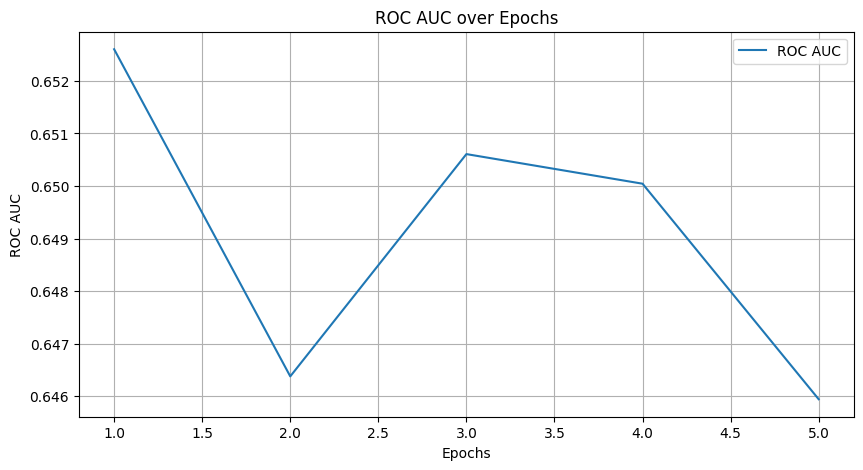

In [31]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(naive_rnn.parameters(), lr=0.001)

n_epochs = 5
roc_aucs = train(naive_rnn, train_loader, val_loader, n_epochs)

plot_roc_auc(roc_aucs)

### RETAIN

RETAIN [4] is a type of neural network designed for interpretability in healthcare applications, especially useful for electronic health records (EHR). RETAIN uses a combination of recurrent neural networks (RNNs) and attention mechanisms to provide interpretable predictions, where the model outputs not only a prediction but also explanations for that prediction in terms of input influence.

Here’s a breakdown of each component and its role within the architecture:

  * Embedding Layer: Converts sparse, categorical input data (like medical codes) into dense vector representations. This transformation helps in capturing and learning the relationships between different codes.

  * Recurrent Neural Networks (RNNs): The architecture uses two GRU (Gated Recurrent Unit) layers, rnn_a and rnn_b. rnn_a layer is used to model the attention weights (alpha) that determine the importance of each visit in a patient's EHR. rnn_b layer models the contributions of different features within each visit (beta), essentially weighting how much each feature within a visit should contribute to the final prediction.

  * Attention Mechanisms: These custom attention mechanisms, AlphaAttention and BetaAttention, are applied to the outputs of the rnn_a and rnn_b respectively.

  * Linear and Sigmoid Output Layers.

In [32]:
class AlphaAttention(torch.nn.Module):

    def __init__(self, embedding_dim):
        super().__init__()

        self.a_att = nn.Linear(embedding_dim, 1)

    def forward(self, g, rev_masks):
        attention_scores = self.a_att(g)

        visit_level_masks = rev_masks.any(dim=2)
        visit_level_masks = visit_level_masks.unsqueeze(-1)

        attention_scores_masked = attention_scores.masked_fill(~visit_level_masks, -1e9)
        alpha = F.softmax(attention_scores_masked, dim=1)

        return alpha

In [33]:
class BetaAttention(torch.nn.Module):

    def __init__(self, embedding_dim):
        super().__init__()

        self.b_att = nn.Linear(embedding_dim, embedding_dim)

    def forward(self, h):
        beta_score = self.b_att(h)
        beta = torch.tanh(beta_score)

        return beta

In [34]:
def attention_sum(alpha, beta, rev_v, rev_masks):
    alpha = alpha.squeeze(-1)
    weighted_visits = (alpha.unsqueeze(-1) * beta * rev_v)

    visit_level_masks = rev_masks.any(dim=2)

    mask_expanded = visit_level_masks.unsqueeze(-1).expand_as(weighted_visits)
    weighted_visits_masked = weighted_visits * mask_expanded
    c = weighted_visits_masked.sum(dim=1)

    return c

In [35]:
def sum_embeddings_with_mask(x, masks):
    x = x * masks.unsqueeze(-1)
    x = torch.sum(x, dim = -2)
    return x

In [36]:
class RETAIN(nn.Module):

    def __init__(self, num_codes, embedding_dim=128):
        super().__init__()
        # Define the embedding layer using `nn.Embedding`. Set `embDimSize` to 128.
        self.embedding = nn.Embedding(num_codes, embedding_dim)
        # Define the RNN-alpha using `nn.GRU()`; Set `hidden_size` to 128. Set `batch_first` to True.
        self.rnn_a = nn.GRU(embedding_dim, embedding_dim, batch_first=True)
        # Define the RNN-beta using `nn.GRU()`; Set `hidden_size` to 128. Set `batch_first` to True.
        self.rnn_b = nn.GRU(embedding_dim, embedding_dim, batch_first=True)
        # Define the alpha-attention using `AlphaAttention()`;
        self.att_a = AlphaAttention(embedding_dim)
        # Define the beta-attention using `BetaAttention()`;
        self.att_b = BetaAttention(embedding_dim)
        # Define the linear layers using `nn.Linear()`;
        self.fc = nn.Linear(embedding_dim, 1)
        # Define the final activation layer using `nn.Sigmoid().
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, masks, rev_x, rev_masks):
        # 1. Pass the reversed sequence through the embedding layer;
        rev_x = self.embedding(rev_x)
        # 2. Sum the reversed embeddings for each diagnosis code up for a visit of a patient.
        rev_x = sum_embeddings_with_mask(rev_x, rev_masks)
        # 3. Pass the reversed embegginds through the RNN-alpha and RNN-beta layer separately;
        g, _ = self.rnn_a(rev_x)
        h, _ = self.rnn_b(rev_x)
        # 4. Obtain the alpha and beta attentions using `AlphaAttention()` and `BetaAttention()`;
        alpha = self.att_a(g, rev_masks)
        beta = self.att_b(h)
        # 5. Sum the attention up using `attention_sum()`;
        c = attention_sum(alpha, beta, rev_x, rev_masks)
        # 6. Pass the context vector through the linear and activation layers.
        logits = self.fc(c)
        probs = self.sigmoid(logits)
        return probs.squeeze(dim=-1)


# Loading the model
retain = RETAIN(num_codes = max_index + 1)
retain

RETAIN(
  (embedding): Embedding(4511, 128)
  (rnn_a): GRU(128, 128, batch_first=True)
  (rnn_b): GRU(128, 128, batch_first=True)
  (att_a): AlphaAttention(
    (a_att): Linear(in_features=128, out_features=1, bias=True)
  )
  (att_b): BetaAttention(
    (b_att): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Epoch: 1 	 Training Loss: 0.563210
Epoch: 1 	 Validation p: 0.61, r:0.25, f: 0.35, roc_auc: 0.67
Epoch: 2 	 Training Loss: 0.375301
Epoch: 2 	 Validation p: 0.53, r:0.28, f: 0.37, roc_auc: 0.65
Epoch: 3 	 Training Loss: 0.206490
Epoch: 3 	 Validation p: 0.50, r:0.30, f: 0.37, roc_auc: 0.63
Epoch: 4 	 Training Loss: 0.088395
Epoch: 4 	 Validation p: 0.52, r:0.29, f: 0.37, roc_auc: 0.63
Epoch: 5 	 Training Loss: 0.034188
Epoch: 5 	 Validation p: 0.49, r:0.30, f: 0.37, roc_auc: 0.62


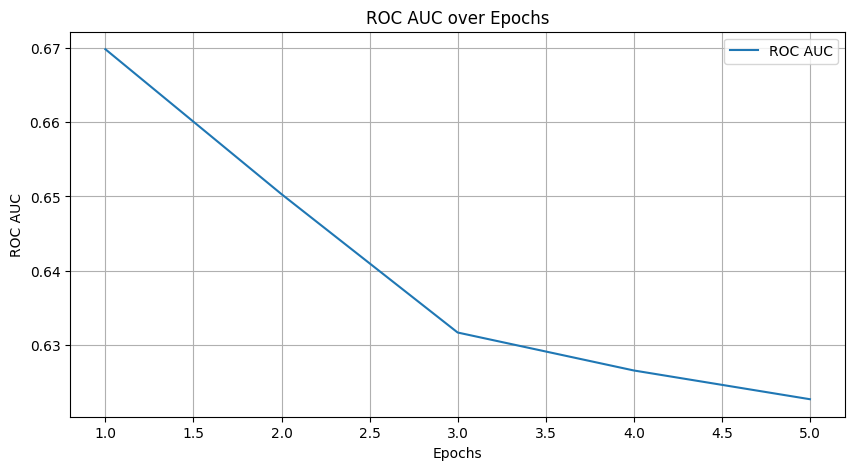

In [37]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(retain.parameters(), lr=1e-3)

n_epochs = 5
roc_aucs = train(retain, train_loader, val_loader, n_epochs)

plot_roc_auc(roc_aucs)

# Results

  * Naive RNN

  Evaluating both the loss metrics and performance metrics (precision, recall, F1-score, and ROC AUC) over multiple epochs, here are what I observe:

    * Training Loss: Training loss decreases consistently from epoch 1 to epoch 5, which suggests that the model is learning and improving its predictions on the training data across epochs.

    * Validation Metrics: The validation metrics from the bi-directional RNN model training indicate a fairly constant performance across epochs with precision hovering around 0.48, recall slightly decreasing from 0.31 to 0.28, and F1-scores reflecting a similar decline from 0.38 to 0.36. The ROC AUC score remains constant at 0.65 throughout the training epochs, suggesting a moderate but unchanging ability to discriminate between classes. These metrics suggest that while the model is consistent in its precision, it's losing some ability to capture all relevant cases (recall) without significant improvement in overall accuracy and predictive balance (F1-score), highlighting potential challenges in model generalization and effectiveness in handling the validation dataset.

    * Overfitting: Given that training loss decreases while validation metrics either remain constant or slightly deteriorate, there may be a concern of overfitting. The model might be learning the training data too precisely, capturing noise rather than just the underlying patterns, which does not generalize well to unseen data.

  * RETAIN

  The results from training the RETAIN model suggest a few key patterns and possible concerns regarding its performance on both training and validation datasets:

    * Training Loss: The training loss shows a clear and consistent decrease from 0.56 in Epoch 1 to 0.03 in Epoch 5. This sharp decrease in loss indicates that the model is effectively learning and improving its performance on the training dataset over time.

    * Validation Metrics: The validation metrics for the RETAIN model over several epochs indicate a challenging pattern, where precision starts relatively high at 0.61 and then drops to 0.49, while recall slightly improves from 0.25 to 0.30. Despite these changes, the F1-score remains moderately stable around 0.37, suggesting that while the model maintains a balance between precision and recall, the overall accuracy and completeness of the predictions are moderate. The ROC AUC score, which assesses the model’s discriminatory power, shows a slight but consistent decline from 0.67 to 0.62.

    * Generalization: Similar to Naive RNN, The decrease in precision and ROC AUC, alongside the decrease in training loss, might suggest overfitting, where the model is increasingly tailored to the training data's specific noise and details at the expense of its generalizability to unseen data.

## Model comparison

Comparing the results from the Naive RNN and RETAIN model with those reported in the paper [1], it is evident that the models used so far underperform relative to the LSTM-based model discussed in the paper. Specifically, the RETAIN model achieves a maximum ROC AUC of 0.67, which is significantly lower than the AUC scores reported in the paper for sepsis prediction, which are 0.952 for same-day prediction and 0.876 for next-day prediction.

The lower performance is most likely due to the following:

  * The LSTM model from the paper incorporates a variable-level attention mechanism, which likely contributes to its superior performance by effectively capturing important time-dependent patterns in the ICU data, thus enhancing its predictive accuracy.

  * The features seleced are only a portion of the viable features that can be used. By expanding the input, better performance will be achieved.

# Discussion
  
  * Make assessment that the paper is reproducible or not: The results obtained from my implementation of the Naive RNN and RETAIN model show substantial differences when compared to the high-performance benchmarks reported in the paper [1]. However, given the more complexity of the proposed model in the paper and more input features used, it is likely that the reported results can be reproduced when these improvements are implemented.
  
  * Explain why it is not reproducible if your results are kind negative: As mentioned earlier, variations in the features characteristics and preprocessing methodscan significantly impact the model's performance. This is probably the reason why performance metrics were lower compared to those reported in the paper.
  
  * Describe “What was easy” and “What was difficult” during the reproduction: Implementing the basic architecture of the Naive RNN and RETAIN models with common components like embeddings, GRUs, and linear layers was straightforward due to the availability of these modules in deep learning frameworks like PyTorch as well as the assigned Homeworks. On the other hand, achieving similar performance metrics as reported in the paper was challenging.
  
  * Make suggestions to the author or other reproducers on how to improve the reproducibility: No suggestions so far!
  
  * What will you do in next phase:

    * Expand Dataset Analysis: Conduct a thorough analysis of the datasets to ensure that they are as similar as possible in terms of preprocessing and feature engineering to what was used in the study.

    * Implement the LSTM with attention model proposed in the paper.

    * Performing ablation studies.

# References

1.   Kaji, D.A., Zech, J.R., Kim, J.S., Cho, S.K., Dangayach, N.S., Costa, A.B. and Oermann, E.K., 2019. An attention based deep learning model of clinical events in the intensive care unit. PloS one, 14(2), p.e0211057.

2.   Henry, K.E., Hager, D.N., Pronovost, P.J. and Saria, S., 2015. A targeted real-time early warning score (TREWScore) for septic shock. Science translational medicine, 7(299), pp.299ra122-299ra122.

3.   Vincent, J.L., Moreno, R., Takala, J., Willatts, S., De Mendonça, A., Bruining, H., Reinhart, C.K., Suter, P. and Thijs, L.G., 1996. The SOFA (Sepsis-related Organ Failure Assessment) score to describe organ dysfunction/failure: On behalf of the Working Group on Sepsis-Related Problems of the European Society of Intensive Care Medicine.

4.   Choi, E., Bahadori, M.T., Sun, J., Kulas, J., Schuetz, A. and Stewart, W., 2016. Retain: An interpretable predictive model for healthcare using reverse time attention mechanism. Advances in neural information processing systems, 29.